# Assignment 3

Deadline: 09.04.2025 12:00 CET

<Add your name, student-id and emal address>

In [1]:
# Standard library imports
import os
import sys
import types

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_msci
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import MeanVariance
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_data_random,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
)
from backtesting.portfolio import floating_weights
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

### Data load

In [2]:
N = 24
data = load_data_msci(path = '../data/', n = N)  #<Change the path if needed>

### Prepare backtest service

In [3]:
# Define rebalancing dates
n_days = 21 * 3
start_date = '2010-01-01'
dates = data['return_series'].index
rebdates = dates[dates > start_date][::n_days].strftime('%Y-%m-%d').tolist()

# Define the selection item builders.
selection_item_builders = {
    'data': SelectionItemBuilder(
        bibfn = bibfn_selection_data_random,
        k = 10,
        seed = 42,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 365 * 3,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.5,
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    optimization = MeanVariance(
        covariance = Covariance(method = 'pearson'),
        expected_return = ExpectedReturn(method = 'geometric'),
        risk_aversion = 1,
        solver_name = 'cvxopt',
    ),
    rebdates = rebdates,
)

### Run the backtest

In [4]:
# Instantiate the backtest object and run the backtest
bt_mv = Backtest()

# Run the backtest
bt_mv.run(bs = bs)

Rebalancing date: 2010-01-04
Rebalancing date: 2010-04-01
Rebalancing date: 2010-06-29
Rebalancing date: 2010-09-24
Rebalancing date: 2010-12-22
Rebalancing date: 2011-03-21
Rebalancing date: 2011-06-16
Rebalancing date: 2011-09-13
Rebalancing date: 2011-12-09
Rebalancing date: 2012-03-07
Rebalancing date: 2012-06-04
Rebalancing date: 2012-08-30
Rebalancing date: 2012-11-27
Rebalancing date: 2013-02-22
Rebalancing date: 2013-05-22
Rebalancing date: 2013-08-19
Rebalancing date: 2013-11-14
Rebalancing date: 2014-02-11
Rebalancing date: 2014-05-09
Rebalancing date: 2014-08-06
Rebalancing date: 2014-11-03
Rebalancing date: 2015-01-29
Rebalancing date: 2015-04-28
Rebalancing date: 2015-07-24
Rebalancing date: 2015-10-21
Rebalancing date: 2016-01-18
Rebalancing date: 2016-04-14
Rebalancing date: 2016-07-12
Rebalancing date: 2016-10-07
Rebalancing date: 2017-01-04
Rebalancing date: 2017-04-03
Rebalancing date: 2017-06-29
Rebalancing date: 2017-09-26
Rebalancing date: 2017-12-22
Rebalancing da

## 1. Turnover

**(6 points)**

Complete the function `turnover`.

In [5]:

def turnover(self, return_series: pd.DataFrame, rescale: bool=True):

    dates = self.get_rebalancing_dates()
    to = {}
    to[dates[0]] = float(1)
    for rebalancing_date in dates[1:]:

        previous_portfolio = self.get_previous_portfolio(rebalancing_date)
        current_portfolio = self.get_portfolio(rebalancing_date)
        print(previous_portfolio)
        
        if current_portfolio.rebalancing_date is None or previous_portfolio.rebalancing_date is None:
            raise ValueError('Portfolios must have a rebalancing date')

        if current_portfolio.rebalancing_date < previous_portfolio.rebalancing_date:
            raise ValueError('The previous portfolio must be older than the current portfolio')

        # Get the union of the ids of the weights in both portfolios (previous and current)
        asset_union = set(previous_portfolio.weights) | set(current_portfolio.weights)

        # Extend the weights of the previous portfolio to the the union of ids in both portfolios by adding zeros
        prev_weights = {k: previous_portfolio.weights.get(k, 0) for k in asset_union}

        # Float the weights of the previous portfolio according to the price drifts in the market 
        # until the current rebalancing date
        # Hint: use function floating_weights from module portfolio.py
        w_float = floating_weights(
            X=return_series,
            w=prev_weights,
            start_date=previous_portfolio.rebalancing_date,
            end_date=current_portfolio.rebalancing_date,
            rescale=rescale
        ).iloc[-1]
        # Extract the weights of the current portfolio
        curr_weights = {k: current_portfolio.weights.get(k, 0) for k in asset_union}

        # Calculate the turnover
        turnover_val = sum(abs(w_float.get(asset, 0) - curr_weights.get(asset, 0)) for asset in asset_union)
        to[rebalancing_date] = turnover_val

    return pd.Series(to)

2: Simulation

(6 points)

Complete the function `simulate`.

In [6]:
def simulate(self,
                return_series: pd.DataFrame,
                fc: float = 0,
                vc: float = 0,
                n_days_per_year: int = 252) -> pd.Series:

    rebdates = self.get_rebalancing_dates()
    ret_list = []
    for rebdate in rebdates:
        next_rebdate = (
            rebdates[rebdates.index(rebdate) + 1]
            if rebdate < rebdates[-1]
            else return_series.index[-1]
        )

        portfolio = self.get_portfolio(rebdate)
        w_float = portfolio.float_weights(
            return_series=return_series,
            end_date=next_rebdate,
            rescale=False # Notice that rescale is hardcoded to False.
        )
        level = w_float.sum(axis=1)
        ret_tmp = level.pct_change(1)
        ret_list.append(ret_tmp)

    portf_ret = pd.concat(ret_list).dropna()

    if vc != 0:
        # Calculate turnover
        to = self.turnover(return_series=return_series,
                           rescale=False)
        # Calculate variable cost (vc) as a fraction of turnover and
        # subtract the variable cost from the returns at each rebalancing date
        cost_series = pd.Series(0, index=portf_ret.index)
        for date, turnover_val in to.items():
            if date in cost_series.index:
                cost_series.loc[date] -= vc * turnover_val

        portf_ret += cost_series

    if fc != 0:
        # Calculate number of days between returns
        # Calculate daily fixed cost based on the annual fixed cost (fc),
        # the number of days between two rebalancings and the number of days per year.
        # Subtract the daily fixed cost from the daily returns
        
        fixed_cost_series = pd.Series(0, index=portf_ret.index)
        for i in range(len(rebdates)):
            start_date = rebdates[i]
            end_date = (
                rebdates[i + 1]
                if i + 1 < len(rebdates)
                else portf_ret.index[-1]
            )
            mask = (portf_ret.index >= start_date) & (portf_ret.index <= end_date)
            n_days = mask.sum()
            if n_days > 0:
                daily_fc = fc / n_days_per_year
                fixed_cost_series.loc[mask] -= daily_fc

        portf_ret += fixed_cost_series


    return portf_ret

Overwrite the turnover and the simulation methods of the current strategy object.

In [7]:
# Overwrite the turnover method of the strategy object
bt_mv.strategy.turnover = types.MethodType(turnover, bt_mv.strategy)

# Overwrite the simulate method of the strategy object
bt_mv.strategy.simulate = types.MethodType(simulate, bt_mv.strategy)

Calculate and plot the turnover.

Portfolio(rebalancing_date=2010-01-04, weights={'DE': 1.0913574496305842e-06, 'GB': 0.4990108332611115, 'BE': 1.9803439476325428e-07, 'CH': 6.857909176769236e-07, 'AT': 1.563569370902817e-07, 'NZ': 1.2119220343134143e-06, 'DK': 0.0009836791884631855, 'JP': 2.70093080698103e-07, 'SE': 3.4401069769286795e-06, 'HK': 0.4999984338886343})
Portfolio(rebalancing_date=2010-04-01, weights={'IE': 1.2588671961135337e-07, 'IT': 3.51636733953385e-07, 'ES': 0.0017218474498538801, 'JP': 3.4240340024493815e-07, 'FI': 6.857447088519153e-07, 'NO': 5.952648315550184e-07, 'GB': 0.4980013086279574, 'SG': 0.4999986124422358, 'US': 1.4913011396931438e-05, 'SE': 0.00026121753216183825})
Portfolio(rebalancing_date=2010-06-29, weights={'ES': 7.133507362068253e-06, 'AU': 0.2350373980259048, 'IL': 0.49999994281701976, 'IT': 2.4218015132830794e-08, 'DE': 5.682902435342942e-06, 'GR': 8.224153801580346e-09, 'CA': 0.26491799752609246, 'PT': 8.309912765785661e-08, 'AT': 1.0901361223728863e-08, 'GB': 3.1718778527554514

<Axes: title={'center': 'Turnover'}>

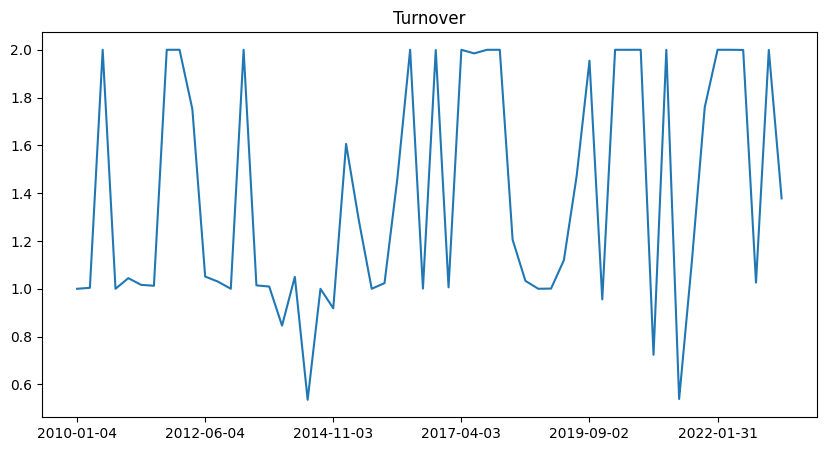

In [8]:
bt_mv.strategy.turnover(
    return_series = data['return_series'],
    rescale = True,
).plot(title = 'Turnover', figsize = (10, 5))


Simulate with different cost assumptions.

In [9]:
return_series = bs.data['return_series']

sim_mv_gross = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0)
sim_mv_net_of_fc = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0)
sim_mv_net_of_vc = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0.002)
sim_mv_net = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0.002)


C:\Users\annaggg\AppData\Local\Temp\ipykernel_31592\2781435167.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.9

Portfolio(rebalancing_date=2010-01-04, weights={'DE': 1.0913574496305842e-06, 'GB': 0.4990108332611115, 'BE': 1.9803439476325428e-07, 'CH': 6.857909176769236e-07, 'AT': 1.563569370902817e-07, 'NZ': 1.2119220343134143e-06, 'DK': 0.0009836791884631855, 'JP': 2.70093080698103e-07, 'SE': 3.4401069769286795e-06, 'HK': 0.4999984338886343})
Portfolio(rebalancing_date=2010-04-01, weights={'IE': 1.2588671961135337e-07, 'IT': 3.51636733953385e-07, 'ES': 0.0017218474498538801, 'JP': 3.4240340024493815e-07, 'FI': 6.857447088519153e-07, 'NO': 5.952648315550184e-07, 'GB': 0.4980013086279574, 'SG': 0.4999986124422358, 'US': 1.4913011396931438e-05, 'SE': 0.00026121753216183825})
Portfolio(rebalancing_date=2010-06-29, weights={'ES': 7.133507362068253e-06, 'AU': 0.2350373980259048, 'IL': 0.49999994281701976, 'IT': 2.4218015132830794e-08, 'DE': 5.682902435342942e-06, 'GR': 8.224153801580346e-09, 'CA': 0.26491799752609246, 'PT': 8.309912765785661e-08, 'AT': 1.0901361223728863e-08, 'GB': 3.1718778527554514

C:\Users\annaggg\AppData\Local\Temp\ipykernel_31592\2781435167.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0020972037831304287' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cost_series.loc[date] -= vc * turnover_val


Portfolio(rebalancing_date=2012-06-04, weights={'HK': 0.3871051711605356, 'GR': 1.7762172427675682e-08, 'NL': 1.8837674267112314e-07, 'FI': 5.560765406577123e-08, 'JP': 1.016284037270607e-07, 'SE': 0.11339776487521143, 'NO': 1.6523327305984247e-07, 'GB': 0.49949486412467176, 'IE': 3.726209815198777e-08, 'CA': 1.633969237131651e-06})
Portfolio(rebalancing_date=2012-08-30, weights={'GB': 0.4850741787297459, 'AT': 7.760339065577325e-08, 'JP': 1.7021226952551408e-07, 'NO': 1.971485987987098e-07, 'ES': 1.6405026413944687e-07, 'FI': 1.2523434168119283e-07, 'BE': 3.147047559693082e-07, 'US': 0.14166852423760032, 'IT': 1.2501875306302965e-07, 'SG': 0.37325612306028})
Portfolio(rebalancing_date=2012-11-27, weights={'FR': 1.4161075658659414e-07, 'FI': 8.527428858646842e-08, 'ES': 1.1122698062043207e-07, 'NO': 1.7373595267723132e-07, 'US': 0.049065417268025976, 'NZ': 0.499989117549544, 'IE': 6.552775526637962e-08, 'DE': 2.0821449675627595e-07, 'IL': 3.4861345931347265e-07, 'GB': 0.450944330978740

C:\Users\annaggg\AppData\Local\Temp\ipykernel_31592\2781435167.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0020972037831304287' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cost_series.loc[date] -= vc * turnover_val
C:\Users\annaggg\AppData\Local\Temp\ipykernel_31592\2781435167.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05
 -3.96825397e-05 -3.96825397e-05 -3.96825397e-05 -3.9682

Plot the cumulative returns.

<Axes: xlabel='Index'>

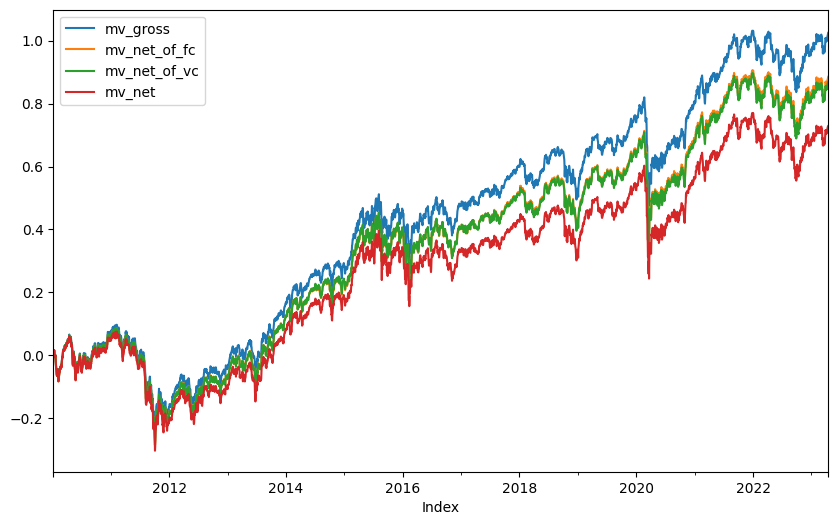

In [10]:
sim = pd.concat({
    'mv_gross': sim_mv_gross,
    'mv_net_of_fc': sim_mv_net_of_fc,
    'mv_net_of_vc': sim_mv_net_of_vc,
    'mv_net': sim_mv_net,
}, axis = 1).dropna()


np.log((1 + sim)).cumsum().plot(figsize = (10, 6))

3: Descriptive Statistics

(3 points)

Generate a table with descriptive statistics of the simulations. Include the following statistics:
- cumulative return (i.e., the return over the entire simulation period)
- annualized average returns
- annualized volatility
- sharpe ratio
- maximum drawdown

In [12]:
import empyrical as ep

sims = [sim_mv_gross, sim_mv_net_of_fc, sim_mv_net_of_vc, sim_mv_net]
stats = ['annual_return', 'cum_returns', 'sharpe_ratio', 'max_drawdown', 'annual_volatility']

# Initialize a dictionary to store the performance metrics
performance_metrics = {
    'cum_returns': [],
    'annual_return': [],
    'annual_volatility': [],
    'sharpe_ratio': [],
    'max_drawdown': [],
    
}
for i in range(len(sims)):
    # Load your strategy returns here
    strategy_returns = sims[i]

    # Compute various performance metrics
    annual_return = ep.annual_return(strategy_returns)
    cumulative_returns = ep.cum_returns(strategy_returns)
    sharpe_ratio = ep.sharpe_ratio(strategy_returns)
    max_drawdown = ep.max_drawdown(strategy_returns)
    annual_volatility = ep.annual_volatility(strategy_returns)

    # Append the metrics to the dictionary
    performance_metrics['annual_return'].append(annual_return)
    performance_metrics['cum_returns'].append(cumulative_returns.iloc[-1])
    performance_metrics['sharpe_ratio'].append(sharpe_ratio)
    performance_metrics['max_drawdown'].append(max_drawdown)
    performance_metrics['annual_volatility'].append(annual_volatility)

performance_df = pd.DataFrame(performance_metrics, index=['mv_gross', 'mv_net_of_fc', 'mv_net_of_vc', 'mv_net'])
# Print the performance metrics DataFrame
performance_df

,cum_returns,annual_return,annual_volatility,sharpe_ratio,max_drawdown
mv_gross,1.786246,0.077347,0.141032,0.599031,-0.305095
mv_net_of_fc,1.422995,0.066461,0.141033,0.526997,-0.309887
mv_net_of_vc,1.382597,0.065158,0.141221,0.517827,-0.310472
mv_net,1.071945,0.054393,0.141225,0.445880,-0.315226
